In [ ]:
# Install required libraries
!pip install transformers datasets scikit-learn torch pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import time
import tracemalloc
import psutil
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
import torch
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset

# Start monitoring memory and runtime
start_time = time.time()
tracemalloc.start()


# Load the dataset
data_path = "/content/twitter_training.csv"
df = pd.read_csv(data_path,on_bad_lines='skip')

# Define the columns of the dataset
df.columns = ['tweet id', 'entity', 'sentiment', 'Tweet content']

# Filter for valid sentiment labels
valid_sentiments = ['Positive', 'Negative', 'Neutral']
df = df[df['sentiment'].isin(valid_sentiments)]

# Map sentiment labels to numerical values
label_mapping = {'Positive': 0, 'Neutral': 1, 'Negative': 2}
df['label'] = df['sentiment'].map(label_mapping)

# Drop rows with missing or non-string Tweet content
df = df.dropna(subset=['Tweet content'])
df['Tweet content'] = df['Tweet content'].astype(str)

# Split data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['Tweet content'], df['label'], test_size=0.2, random_state=42
)

# Verify the split
print(f"Number of training samples: {len(train_texts)}")
print(f"Number of testing samples: {len(test_texts)}")

# Stop monitoring
end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
print(f"Data Preprocessing Runtime: {end_time - start_time:.2f} seconds")
print(f"Data Preprocessing Memory Usage: {current / 1024 ** 2:.2f} MB")
print(f"Data Preprocessing Peak Memory Usage: {peak / 1024 ** 2:.2f} MB")
tracemalloc.stop()



Number of training samples: 48896
Number of testing samples: 12224
Data Preprocessing Runtime: 0.37 seconds
Data Preprocessing Memory Usage: 15.90 MB
Data Preprocessing Peak Memory Usage: 18.17 MB


In [ ]:
# Start monitoring
start_time = time.time()
tracemalloc.start()

# Initialize DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize the data
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding=True, max_length=128)

# Create Hugging Face Datasets
train_dataset = Dataset.from_dict({'text': train_texts.tolist(), 'label': train_labels.tolist()})
test_dataset = Dataset.from_dict({'text': test_texts.tolist(), 'label': test_labels.tolist()})

# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Stop monitoring
end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
print(f"Tokenization Runtime: {end_time - start_time:.2f} seconds")
print(f"Tokenization Memory Usage: {current / 1024 ** 2:.2f} MB")
print(f"Tokenization Peak Memory Usage: {peak / 1024 ** 2:.2f} MB")
tracemalloc.stop()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/48896 [00:00<?, ? examples/s]

Map:   0%|          | 0/12224 [00:00<?, ? examples/s]

Tokenization Runtime: 135.24 seconds
Tokenization Memory Usage: 10.68 MB
Tokenization Peak Memory Usage: 45.55 MB


In [ ]:
# Load pre-trained DistilBERT model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,  # Adjust batch size based on memory
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_total_limit=2,
    fp16=True,  # Mixed precision training for efficiency
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-5-e0e182c1ee6c>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Start monitoring
start_time = time.time()
tracemalloc.start()

# Train the model
trainer.train()
print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1e6} MB")
print(f"GPU memory cached: {torch.cuda.memory_reserved() / 1e6} MB")
# Stop monitoring
end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
print(f"Training Runtime: {end_time - start_time:.2f} seconds")
print(f"Training Memory Usage: {current / 1024 ** 2:.2f} MB")
print(f"Training Peak Memory Usage: {peak / 1024 ** 2:.2f} MB")
tracemalloc.stop()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,0.496000,0.411157
2,0.149500,0.282318
3,0.187900,0.291555


GPU memory allocated: 829.417984 MB
GPU memory cached: 1648.361472 MB
Training Runtime: 827.01 seconds
Training Memory Usage: 16.01 MB
Training Peak Memory Usage: 271.68 MB


Evaluation Runtime: 22.32 seconds
Evaluation Memory Usage: 0.35 MB
Evaluation Peak Memory Usage: 0.45 MB
Classification Report:
              precision    recall  f1-score   support

    Positive       0.90      0.92      0.91      4101
     Neutral       0.92      0.90      0.91      3679
    Negative       0.93      0.92      0.93      4444

    accuracy                           0.92     12224
   macro avg       0.92      0.91      0.91     12224
weighted avg       0.92      0.92      0.92     12224



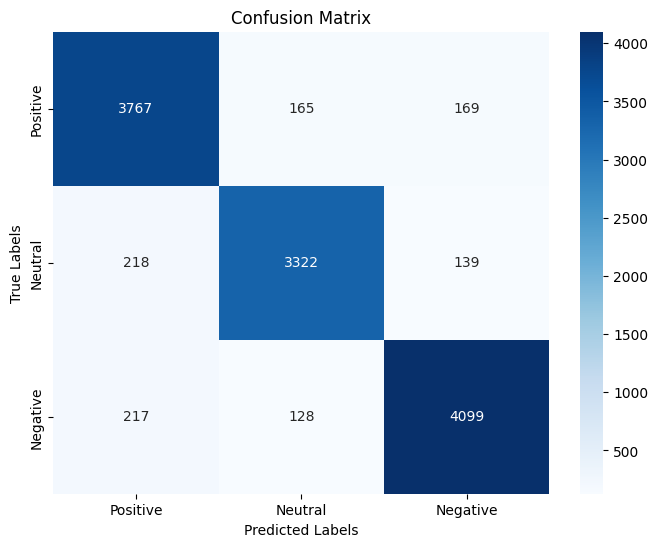

In [ ]:
# Start monitoring
start_time = time.time()
tracemalloc.start()

# Evaluate the model
results = trainer.evaluate()

# Stop monitoring
end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
print(f"Evaluation Runtime: {end_time - start_time:.2f} seconds")
print(f"Evaluation Memory Usage: {current / 1024 ** 2:.2f} MB")
print(f"Evaluation Peak Memory Usage: {peak / 1024 ** 2:.2f} MB")
tracemalloc.stop()

# Get predictions and true labels
predictions = trainer.predict(test_dataset)
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), axis=1).numpy()
true_labels = predictions.label_ids

# Print evaluation metrics
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=['Positive', 'Neutral', 'Negative']))

# Generate and plot confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Neutral', 'Negative'], yticklabels=['Positive', 'Neutral', 'Negative'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

